According to the International Diabetes Federation, type 2 diabetes accounts for ~90% of all cases of diabetes, resulting in an estimated 6.7 million deaths in 2021. By 2030 the World Health Organisation (WHO) predicts 366 million people with diabetes (∼5% of the world's population). Therefore, Early detection of type 2 diabetes is important for the prevention of diabetic complications. Early detection of patients with a high risk of developing type 2 diabetes can reduce the occurrence of the disease with a change in lifestyle, diet, or medication.

The data provided has 500 entries (each representing an individual person) and 15 columns. These columns are described in the following table :

![](data_info.png)


A colleague from the Data Analytics team argued that there is no need to follow the medical team’s recommendations to use the above-mentioned articles, saying that you only need to clean the dataset before training your model(s) without any need to investigate further attributes. They say that you can choose features solely according to their correlation with the dependent variable. As part of your solution, you should state which approach you think is optimal for this task and justify your answer.

So, the solution involves building a model based on colleague's recommendations and another in a traditional approach.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer



import warnings
warnings.filterwarnings('ignore')

### Methods for data cleaning
Replace : replacing the zeros with NaN and later, replacing them with most frequent values (mode)
Remove  : removing the records with NaN or 0 values

In [6]:
def handle_missing_values(df, strategy = 'remove'):
    if strategy == 'remove':
        df.dropna(inplace=True)
        df.drop_duplicates(inplace=True)
    else:
        #Replacing NaN values with selected features like most_frequent, median, mean
        imputer = SimpleImputer(missing_values=np.NaN, strategy=strategy)
        imputer = imputer.fit(df)
        df_imp = imputer.transform(df)
        df = pd.DataFrame(df_imp, columns=df.columns)
    return df

def remove_zeroes(df):
    remove_zeroes_list = ['Height /stature (cm)', 'weight1 (Kg)', 'weight2(Kg)', 'BMI (Kg/m^2)', 'waist (cm)', 'hip (cm)']
    for feature in remove_zeroes_list:
        null_indices = df[df[feature] == 0].index
        print('Cleaning Zero values in Feature : ' + feature + ' - ', null_indices.values)
        df.drop(null_indices, inplace=True)
    return df

def handle_zeroes(df, strategy = 'replace'):
    if strategy == 'remove':
        df = remove_zeroes(df)
    else:
        df.replace(0, np.NaN, inplace=True)
    return df

### Methods to test models (Generic)
default test_size as 0.25
Helper method to compare multiple models performance on same data

In [7]:
def test_models(X, Y, models, test_size = 0.25):
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= test_size, random_state=42)

    default_compare = ['accuracy', 'recall']
    compare_model_results = pd.DataFrame(columns = default_compare)

    n_f = len(x_train.columns)

    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        compare_model_results.loc[str(model)] = [accuracy, recall]

        # print('Model : ', type(model))
        # print('Accuracy for : {:.2f}'.format(accuracy_score(y_test, y_pred)))
        # print('Recall for : {:.2f}'.format(recall_score(y_test, y_pred)))
        # print('------------------------------------------------')
    print(compare_model_results)

Generic method to run and model and print eval scores like Accuracy, Recall and Classification Report

In [45]:
from sklearn.metrics import balanced_accuracy_score


def execute_model(X, Y, model, scores = ['accuracy', 'recall'], test_size=0.25):
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= test_size, random_state=42)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    if 'accuracy' in scores:
        print('Accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred)))
    if 'b_accuracy' in scores:
        print('Balanced Accuracy : {:.2f}'.format(balanced_accuracy_score(y_test, y_pred)))
    if 'recall' in scores:
        print('Recall : {:.2f}'.format(recall_score(y_test, y_pred)))
    if 'report' in scores:
        print('Classification Report :' , classification_report(y_test, y_pred))



Method return a Voting Classifier with mentioned models as estimators

In [10]:
def voting_ensemble(models):
    estimators = []
    for model in models:
        est = (str(model) , model)
        estimators.append(est)

    return VotingClassifier(estimators=estimators, voting='hard')

### Helper methods to get X and Y
To get the features set and target set seperately

In [11]:
def get_x(data, req_columns=None):
    if req_columns is None:
        req_columns = []
    if len(req_columns) > 0:
        return data[req_columns]
    return data.drop(columns = ['Diabetes'])

def get_y(data):
    return data.Diabetes

### Methods to add features
Based on the insights from Article 1 (Wang et al., 2016), WHR (waist-to-hip ratio), WSR (waist-to-stature ratio), and BMI (body mass index) are significantly associated with type 2 diabetes. Since, we already have BMI in the dataset, creating WSR and WHR as new features and removing the redundant features.

In [12]:
def add_wsr(df):
    df["WSR"] = df['waist (cm)'] / df['Height /stature (cm)']
    # df.drop(columns=['waist (cm)', 'Height /stature (cm)'], inplace=True)
    return df

def add_whr(df):
    df["WHR"] = df['waist (cm)'] / df['hip (cm)']
    df.drop(columns=['waist (cm)', 'Height /stature (cm)', 'hip (cm)', 'weight1 (Kg)', 'weight2(Kg)'], inplace=True)
    return df


### Methods to convert numerical features into categorical

Article 4 (TheHealthSite, 2015) states that cholesterol levels can be further categorised based on their relation with Type 2 Diabetes. Therefore, based on the information from the article, we have categorised the data into two types - 1 and 0, where
0 represents normal levels,
1 illustrates the risk for diabetes.

In [13]:
def convert_cholesterol_features(df):
    df[' Cholesterol (mg/dl)'] = df[' Cholesterol (mg/dl)'].apply(lambda x : 1 if x > 240 else 0)
    df['HDL Chol (mg/dl)'] = df['HDL Chol (mg/dl)'].apply(lambda x : 1 if x < 40 else 0)
    df['TChol/HDL ratio'] = df['TChol/HDL ratio'].apply(lambda x : 1 if x > 4.5 else 0)
    return df

The risk levels of Glucose for Diabetes were mentioned in Article 5 (Centers for Disease Control and Prevention, 2019). Based on that information, we divided Glucose data into two groups - normal (0) and high (1).

In [14]:
def convert_glucose(df):
    df['Glucose (mg/dl)'] = df['Glucose (mg/dl)'].apply(lambda x : 1 if x > 100 else 0)
    return df

Based on the results and research in Articles 1 and 3 (Wang et al., 2016 and Lee, Han and Kwon, 2019) related to Diabetes and insights into its relationship with age, we divided the data into two groups - < 50 and >= 50.

In [15]:
def convert_age(df):
    df['Age'] = df['Age'].apply(lambda x : 1 if x >= 50 else 0)
    return df

Based on the results from Article 2 (Hillier and Pedula, 2001), considering the relation between age and blood pressure values for diabetes cases, we created a consolidated feature indicating high risk (1) and normal (0) levels using Age, SBP and DBP features.

In [16]:
def map_age_bp(x):
    if x['Age'] < 40:
        if x['Systolic BP'] > 110 and x['Diastolic BP'] > 70:
            return 1
        return 0
    elif x['Age'] >= 40:
        if x['Systolic BP'] > 115 and x['Diastolic BP'] > 70:
            return 1
        return 0

def convert_bp(df):
    df['BP'] = df.apply(lambda x: map_age_bp(x), axis=1)
    df.drop(columns=['Systolic BP', 'Diastolic BP'], inplace=True)
    return df

Mapping the BMI values in combination with Age into 2 categories, i.e., low risk(0) and high risk(1)

In [17]:
def map_age_bmi(age, bmi):
    if (age >= 50 and bmi >= 25) or (age < 50 and bmi >= 29):
        return 1
    return 0

def convert_bmi(df):
    df['BMI (Kg/m^2)'] = df.apply(lambda x : map_age_bmi(x['Age'], x['BMI (Kg/m^2)']), axis=1)
    return df

### Feature Selection Algorithms

Performing Recursive Feature Elimination Algorithm to pick the best features required to process and build the model

In [18]:
def rfe_feature_selection(df, i = 0):
    X = df.drop("Diabetes", axis=1)
    y = df["Diabetes"]

    # model = LogisticRegression()
    if i == 0:
        rfe = RFE(estimator=DecisionTreeClassifier())
    else:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select = i)
    # rfe = RFE(model)
    rfe.fit(X, y)

    important_features = X.columns[rfe.get_support()]
    print('Features by RFE : ', important_features)
    return important_features

Using the Chi-squared test, we are picking the features that are significant in predicting Diabetes

In [19]:
def k_best_feature_selection(df, k = None):
    x_tmp = get_x(df)
    y_tmp = get_y(df)

    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(x_tmp,y_tmp)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x_tmp.columns)

    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Scores']
    # print(featureScores.nlargest(15,'Scores').Features.values)
    if k is None:
        return featureScores.nlargest(len(dfcolumns),'Scores').Features.values
    return featureScores.nlargest(k,'Scores').Features.values

In [20]:
def select_by_corr(df_corr):
    corr_matrix = df_corr.corr()

    # select the absolute value of correlation of dependent variable with other variables
    corr_matrix_dependent = abs(corr_matrix["Diabetes"])

    # select highly correlated features
    relevant_features = corr_matrix_dependent[corr_matrix_dependent >= 0.15]

    print('Features by correlation values :- ')
    if 'Diabetes' in relevant_features.index:
        relevant_features = relevant_features.drop( labels = 'Diabetes')

    print(relevant_features.index)
    return relevant_features.index
    # df_filtered = df_filtered[relevant_features.index]

In [21]:
def compare_performance_by_features(df, features, model):

    default_compare = ['accuracy', 'recall']
    compare_feature_results = pd.DataFrame(columns = default_compare)

    max_score = -100
    best_index = 2
    for i in range(2, len(features)):
        sub_features = features[0:i]

        sub_dx = get_x(df, sub_features)
        sub_dy = get_y(df)

        x_train, x_test, y_train, y_test = train_test_split(sub_dx,sub_dy, test_size= 0.25, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        compare_feature_results.loc[str(model) + ' with features = ' + str(i)] = [accuracy, recall]
        if max_score < recall:
            best_index = i
            max_score = recall

    print(compare_feature_results)
    return best_index

In [22]:
def pca_eval(df, cols):
    pca = PCA(n_components=len(cols))
    pca.fit(df[cols])

    print('Explained variance ratio : ', pca.explained_variance_ratio_ * 100)

    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
    plt.axhline(y=80, color='green', linestyle='--')
    plt.title("PCA Visualised : Cumulative Variance % vs Components")
    plt.xlabel('# of Components')
    plt.ylabel('Cumulative % of explained variance')
    plt.xticks([i for i in range(1, (len(cols) + 1))])

### Methods to follow Approach suggested by colleague

After cleaning the data, as suggested by a colleague, instead of analysing the features, we are performing the chi-squared test for feature selection. Then, based on the Chi Squared ranking, we build a model that recursively adds features.

Later based on the performance of those models, we selected the number of features that yielded the best performance.

In [23]:
def direct_approach(df, feature_selection = None, feature_count = 0, zeroes_strat = 'replace', missing_strat = 'most_frequent'):

    dfd_cleaned = handle_zeroes(df, zeroes_strat)
    dfd_cleaned = handle_missing_values(dfd_cleaned, missing_strat)

    dfd_cleaned.Gender = dfd_cleaned.Gender.map({'male': 1, 'female': 0})
    dfd_cleaned.Diabetes = dfd_cleaned.Diabetes.map({'Diabetes': 1, 'No diabetes': 0})

    dfd_cleaned = dfd_cleaned.apply(pd.to_numeric)

    important_features = []
    if feature_selection == 'rfe':
        important_features = rfe_feature_selection(dfd_cleaned)
    elif feature_selection == 'k_best':
        if feature_count > 0:
            important_features = k_best_feature_selection(dfd_cleaned, feature_count)
            best_f = feature_count
        else:
            important_features = k_best_feature_selection(dfd_cleaned)
            rf = RandomForestClassifier()
            best_f = compare_performance_by_features(dfd_cleaned, important_features, rf)

    print('')
    print('')
    print('Based on above process, we have better recall rate for ' + str(best_f) + ' features')

    final_dx = get_x(dfd_cleaned, important_features[0:best_f])
    final_dy = get_y(dfd_cleaned)

    execute_model(final_dx, final_dy, RandomForestClassifier(), ['recall', 'accuracy'])

    if feature_count == 0:
        print('')
        print('')
        print('Checking performance when picked features soley based on correlation with target variable')
        corr_features = select_by_corr(dfd_cleaned)
        corr_dx = get_x(dfd_cleaned, corr_features)
        corr_dy = get_y(dfd_cleaned)
        execute_model(corr_dx, corr_dy, RandomForestClassifier(), ['recall', 'accuracy'])

    print('')
    print('')
    print('Comparing performance of selected apporach with different models and their Voting Ensemble')
    rf = RandomForestClassifier()
    gb = GradientBoostingClassifier()
    svm = SVC()
    dt = DecisionTreeClassifier()
    vc_ensemble_d = voting_ensemble([rf, gb, dt])
    test_models(final_dx, final_dy, [rf, gb, dt, vc_ensemble_d])
    return final_dx, final_dy, vc_ensemble_d

### SOLUTION -------

Loading and cleaing the data (replacing missing values with the most frequent strategy using Imputer)

In [25]:
df_raw = pd.read_csv('./Data/Diabetes_raw_dataset.csv')
df_raw.drop(columns = ['Patient number'], inplace=True)


# df_cleaned = clean_data(df_raw)
df_cleaned = handle_zeroes(df_raw)
df_cleaned = handle_missing_values(df_cleaned, 'most_frequent')

df_cleaned.Gender = df_cleaned.Gender.map({'male': 1, 'female': 0})
df_cleaned.Diabetes = df_cleaned.Diabetes.map({'Diabetes': 1, 'No diabetes': 0})
df_cleaned = df_cleaned.apply(pd.to_numeric)
# print(df_cleaned.dtypes)
df_cleaned.head()

,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,Height /stature (cm),weight1 (Kg),weight2(Kg),BMI (Kg/m^2),Systolic BP,Diastolic BP,waist (cm),hip (cm),Diabetes
0,193.0,77.0,49.0,3.9,19,0,154.9,54.93,54.0,22.88,118.0,70.0,81.3,96.5,0
1,146.0,79.0,41.0,3.6,19,0,152.4,98.97,61.0,42.61,108.0,58.0,83.8,101.6,0
2,217.0,75.0,54.0,4.0,20,0,170.2,116.22,85.0,40.13,110.0,72.0,101.6,114.3,0
3,226.0,97.0,70.0,3.2,20,0,162.6,54.03,52.0,20.44,122.0,64.0,78.7,99.1,0
4,164.0,91.0,67.0,2.4,20,0,177.8,83.08,64.0,26.28,122.0,86.0,81.3,99.1,0


### Approach - 1: Approach Suggested by Medial Team by analysing columns with help of provided articles

### Approach - 1: Adding new Features

In [26]:
df_new_f = df_cleaned.copy()
df_new_f = add_wsr(df_new_f)
df_new_f = add_whr(df_new_f)

Approach - 1: Converting the features into categorical data

In [27]:
df_c = df_new_f.copy()
df_c = convert_cholesterol_features(df_c)
df_c = convert_glucose(df_c)
df_c = convert_bp(df_c)
df_c = convert_bmi(df_c)
df_c = convert_age(df_c)

### Approach - 1: Without Feature Selection
Checking performance without any explicit feature selection

In [30]:
data_nfs = df_c.copy()
print('')
print('Comparing performance of different models and their Voting Ensemble')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
svm = SVC()
dt = DecisionTreeClassifier()
test_models(get_x(data_nfs), get_y(data_nfs), [rf, gb, dt,  voting_ensemble([rf, gb, dt])])


Comparing performance of different models and their Voting Ensemble
                                                    accuracy  recall
RandomForestClassifier()                               0.896  0.6250
GradientBoostingClassifier()                           0.912  0.7500
DecisionTreeClassifier()                               0.880  0.8125
VotingClassifier(estimators=[('RandomForestClas...     0.912  0.7500


In [32]:
df_c.head()

,Cholesterol (mg/dl),Glucose (mg/dl),HDL Chol (mg/dl),TChol/HDL ratio,Age,Gender,BMI (Kg/m^2),Diabetes,WSR,WHR,BP
0,0,0,0,0,0,0,0,0,0.524855,0.842487,0
1,0,0,0,0,0,0,1,0,0.549869,0.824803,0
2,0,0,0,0,0,0,1,0,0.596945,0.888889,0
3,0,0,0,0,0,0,0,0,0.484010,0.794147,0
4,0,0,0,0,0,0,0,0,0.457255,0.820383,1


### Approach - 1: Feature Section with help of RFE (Recursive Feature Elimination) and PCA (Principal Component Analysis)
performing RFE and evaluating with PCA to

Explained variance ratio :  [23.9538312  20.045892   15.1705293  10.13981911  9.67674011  9.10017155
  7.04419398  4.24915264  0.48563895  0.13403114]
Features by RFE :  Index([' Cholesterol (mg/dl)', 'Glucose (mg/dl)', 'TChol/HDL ratio', 'Age',
       'Gender', 'WSR', 'WHR', 'BP'],
      dtype='object')


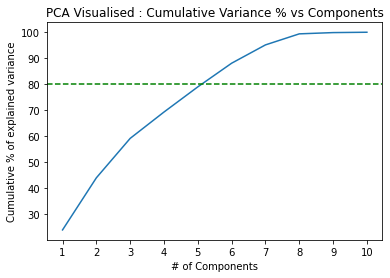

In [39]:
data_nfs = df_c.copy()
pca_eval(data_nfs,df_c.drop(columns=['Diabetes']).columns)

rfe_features = rfe_feature_selection(data_nfs, i=8)

We are using RFE to select features and evaluate feasibility with PCA to determine the number of features.

### Approach - 1: : Comparing performance after Feature Selection

In [40]:
final_x = data_nfs[rfe_features]
final_y = get_y(data_nfs)
print('')
print('Comparing performance of selected apporach with different models and their Voting Ensemble')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
svm = SVC()
dt = DecisionTreeClassifier()
vc_ensemble = voting_ensemble([rf, gb, dt])
test_models(final_x, final_y, [rf, gb, dt, vc_ensemble])


Comparing performance of selected apporach with different models and their Voting Ensemble
                                                    accuracy  recall
RandomForestClassifier()                               0.888  0.6250
GradientBoostingClassifier()                           0.912  0.7500
DecisionTreeClassifier()                               0.896  0.8125
VotingClassifier(estimators=[('RandomForestClas...     0.920  0.7500


We would like to focus more on not missing the diabetic outcomes. So, it is important to consider the true positive rate (Recall rate) focusing identifying diabetic outcomes (reducing false negative rate).

In [46]:
# execute_model(final_x, final_y, vc_ensemble, ['accuracy', 'recall', 'report'])
execute_model(final_x, final_y, DecisionTreeClassifier(), ['accuracy', 'recall', 'report', 'b_accuracy'])

Accuracy : 0.87
Balanced Accuracy : 0.85
Recall : 0.81
Classification Report :               precision    recall  f1-score   support

           0       0.97      0.88      0.92       109
           1       0.50      0.81      0.62        16

    accuracy                           0.87       125
   macro avg       0.73      0.85      0.77       125
weighted avg       0.91      0.87      0.88       125



### Approach - 2: As suggested by colleague, building model without referring any articles

In [49]:
final_dx, final_dy, vc_ensemble_d = direct_approach(df_raw.copy(), 'k_best')

                                             accuracy  recall
RandomForestClassifier() with features = 2      0.944  0.7500
RandomForestClassifier() with features = 3      0.960  0.8125
RandomForestClassifier() with features = 4      0.952  0.8125
RandomForestClassifier() with features = 5      0.952  0.8125
RandomForestClassifier() with features = 6      0.952  0.8750
RandomForestClassifier() with features = 7      0.952  0.8750
RandomForestClassifier() with features = 8      0.952  0.8750
RandomForestClassifier() with features = 9      0.936  0.8750
RandomForestClassifier() with features = 10     0.936  0.8125
RandomForestClassifier() with features = 11     0.944  0.8750
RandomForestClassifier() with features = 12     0.944  0.7500
RandomForestClassifier() with features = 13     0.960  0.8125


Based on above process, we have better recall rate for 6 features
Accuracy : 0.94
Recall : 0.88


Checking performance when picked features soley based on correlation with target variable
Feat

Based on the results from the (Approach - 2) direct approach as mentioned above, the Ensemble (Voting Classifier) has a better performance compared to other models.

For Approach - 2, checking the performance if we remove the missing or Nan data during the cleaning phase instead of replacing them with the most frequent values.

In [230]:
a,b,c = direct_approach(df_raw.copy(), 'k_best', 0, 'remove', 'remove')

Cleaning Zero values in Feature : Height /stature (cm) -  []
Cleaning Zero values in Feature : weight1 (Kg) -  []
Cleaning Zero values in Feature : weight2(Kg) -  []
Cleaning Zero values in Feature : BMI (Kg/m^2) -  []
Cleaning Zero values in Feature : waist (cm) -  []
Cleaning Zero values in Feature : hip (cm) -  []
                                             accuracy    recall
RandomForestClassifier() with features = 2       0.91  0.666667
RandomForestClassifier() with features = 3       0.90  0.750000
RandomForestClassifier() with features = 4       0.91  0.750000
RandomForestClassifier() with features = 5       0.93  0.750000
RandomForestClassifier() with features = 6       0.92  0.750000
RandomForestClassifier() with features = 7       0.92  0.750000
RandomForestClassifier() with features = 8       0.91  0.666667
RandomForestClassifier() with features = 9       0.92  0.750000
RandomForestClassifier() with features = 10      0.92  0.750000
RandomForestClassifier() with features = 

As we can see from the above results, performance is better when we replaced the missing data instead of removing them.

### Approach - 2: Final Model
Voting Model with Random Forest, Gradient Boosting and Decision Tree Classifiers as estimators.

In [223]:
execute_model(final_dx, final_dy, vc_ensemble_d, ['accuracy', 'recall', 'report'])

Accuracy : 0.96
Recall : 0.94
Classification Report :               precision    recall  f1-score   support

           0       0.99      0.96      0.98       109
           1       0.79      0.94      0.86        16

    accuracy                           0.96       125
   macro avg       0.89      0.95      0.92       125
weighted avg       0.96      0.96      0.96       125



### Conclusion :

As suggested by the medical team, we have processed the data by analysing the features using the articles for each feature. First, we have converted the numerical features into categorical features. Then, using RFE and PCA, we picked the most significant features. We are using a Voting Classifier as the Ensemble system of Random Forrest, Decision Tree and Gradient Boosting Classifiers. This approach produces an accuracy of about 90 and a recall rate of 75 for the prediction of Diabetes. However, decision tree classifier alone was able to produce a model with 81 recall rate.

As suggested by a colleague, the data was processed without considering the article and following a similar process and using the Voting Classifier with ensemble of Random Forrest, Gradient Boosting and Decision model, we achieved a better performance.

Using the second approach, we have achieved 94 recall rates and 96 accuracy, which is better than Approach 1.

Since the recall rate shows the ability to predict a patient with diabetes as diabetes, it can be considered the prime indicator. So, Approach 2 seems to be the better approach in this scenario and with the data available for diabetes prediction

### References

1. Wang, S., Ma, W., Yuan, Z., Wang, S., Yi, X., Jia, H. and Xue, F. (2016). Association between obesity indices and type 2 diabetes mellitus among middle-aged and elderly people in Jinan, China: a cross-sectional study. BMJ Open, [online] 6(11), p.e012742. doi:10.1136/bmjopen-2016-012742.
2. Hillier, T.A. and Pedula, K.L. (2001). Characteristics of an Adult Population With Newly Diagnosed Type 2 Diabetes: The relation of obesity and age of onset. Diabetes Care, 24(9), pp.1522–1527. doi:10.2337/diacare.24.9.1522. Available at: https://diabetesjournals.org/care/article/24/9/1522/21378/Characteristics-of-an-Adult-Population-With-Newly
3. Lee, M.-K., Han, K. and Kwon, H.-S. (2019). Age-specific diabetes risk by the number of metabolic syndrome components: a Korean nationwide cohort study. Diabetology & Metabolic Syndrome, 11(1). doi:10.1186/s13098-019-0509-8. Available at: https://dmsjournal.biomedcentral.com/articles/10.1186/s13098-019-0509-8
4. TheHealthSite. (2015). Everything you wanted to know about — cholesterol, lipid profile, VLDL, HDL and triglycerides | TheHealthSite.com. [online] Available at: https://www.thehealthsite.com/diseases-conditions/common-queries-about-cholesterol-lipid-profile-vldl-hdl-triglycerides-4697/.
5. Centers for Disease Control and Prevention (2019). Diabetes Tests. [online] Centers for Disease Control and Prevention. Available at: https://www.cdc.gov/diabetes/basics/getting-tested.html.
6. Edlitz, Y. and Segal, E. (2022). Prediction of type 2 diabetes mellitus onset using logistic regression-based scorecards. eLife, 11. doi:10.7554/elife.71862.
7. Goldingay, H. and Hadi, M. (2022), CS4730_P1_A Machine Learning (2022-2023), MSc AI, Aston University.